In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import kagglehub
import os 

nba_stats_path = kagglehub.dataset_download("rodneycarroll78/nba-stats-1980-2024")
salary_path = kagglehub.dataset_download("ratin21/nba-player-stats-and-salaries-2000-2025")

C:\Users\andno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
advanced_80to24 = pd.read_csv(os.path.join(nba_stats_path, 'Advanced.csv'))
ppg_80to24 = pd.read_csv(os.path.join(nba_stats_path, 'Player Per Game.csv'))
season_info_80to24 = pd.read_csv(os.path.join(nba_stats_path, 'Player Season Info.csv'))
salaries_00to25 = pd.read_csv(os.path.join(salary_path, 'NBA Player Stats and Salaries_2000-2025.csv'))
recent_season = pd.read_csv("https://raw.githubusercontent.com/mikvyork/schulich_data_science/065a74a55363f17c4ea0eb708332d3216483ee50/mban6110_a3/2425regseason.csv")

MERGE DATASETS

In [3]:
advanced_80to24.columns 

Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'mp', 'per', 'ts_percent', 'x3p_ar',
       'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent',
       'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows',
       'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp'],
      dtype='object')

In [4]:
recent_season.columns 

Index(['Player▲', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [5]:
recent_season = recent_season.rename(columns = {'Player▲' : 'Player'}) 

In [6]:
recent_season 

,Player,Age,Team,Pos,G,GS,MP,PER,TS%,3PAr,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,25,NYK,C,57,10,1170,13.6,0.530,0.110,...,0.594,1.8,3.8,5.6,1.0,0.8,0.7,0.8,1.4,6.6
1,Steven Adams,31,HOU,C,58,3,794,16.6,0.541,0.012,...,0.462,2.9,2.8,5.6,1.1,0.4,0.5,0.9,1.0,3.9
2,Bam Adebayo,27,MIA,C,78,78,2674,18.9,0.561,0.199,...,0.765,2.4,7.2,9.6,4.3,1.3,0.7,2.1,2.1,18.1
3,Ochai Agbaji,24,TOR,SG,64,45,1739,12.0,0.601,0.474,...,0.708,1.0,2.8,3.8,1.5,0.9,0.5,0.8,2.0,10.4
4,Santi Aldama,24,MEM,PF,65,16,1660,16.8,0.588,0.503,...,0.691,1.4,5.0,6.4,2.9,0.8,0.4,1.1,1.2,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,Delon Wright,32,2TM,PG,40,7,635,9.2,0.440,0.557,...,0.600,0.7,1.0,1.7,1.9,0.9,0.3,0.6,0.6,3.1
565,Guerschon Yabusele,29,PHI,C,70,43,1895,14.7,0.616,0.487,...,0.725,1.9,3.7,5.6,2.1,0.8,0.3,1.2,2.3,11.0
566,Jahmir Young,24,CHI,PG,6,0,30,16.8,0.935,0.400,...,1.000,0.2,0.3,0.5,1.0,0.0,0.0,0.2,0.3,1.8
567,Trae Young,26,ATL,PG,76,76,2739,18.3,0.567,0.467,...,0.875,0.5,2.6,3.1,11.6,1.2,0.2,4.7,1.9,24.2


In [7]:
advanced_80to24 = advanced_80to24.rename(columns={
    'player': 'Player',
    'pos': 'Pos',
    'age': 'Age',
    'tm': 'Team',
    'g': 'G',
    'mp': 'MP',
    'per': 'PER',
    'ts_percent': 'TS%',
    'x3p_ar': '3PAr',
    'f_tr': 'FTr',
    'orb_percent': 'ORB%',
    'drb_percent': 'DRB%',
    'trb_percent': 'TRB%',
    'ast_percent': 'AST%',
    'stl_percent': 'STL%',
    'blk_percent': 'BLK%',
    'tov_percent': 'TOV%',
    'usg_percent': 'USG%',
    'ows': 'OWS',
    'dws': 'DWS',
    'ws': 'WS',
    'ws_48': 'WS/48',
    'obpm': 'OBPM',
    'dbpm': 'DBPM',
    'bpm': 'BPM',
    'vorp': 'VORP'
})

In [8]:
ppg_80to24 = ppg_80to24.rename(columns={
    'player': 'Player',
    'pos': 'Pos',
    'age': 'Age',
    'g': 'G',
    'tm': 'Team',
    'gs': 'GS',
    'season': 'Season',
    'fg_per_game': 'FG',
    'fga_per_game': 'FGA',
    'fg_percent': 'FG%',
    'x3p_per_game': '3P',
    'x3pa_per_game': '3PA',
    'x3p_percent': '3P%',
    'x2p_per_game': '2P',
    'x2pa_per_game': '2PA',
    'x2p_percent': '2P%',
    'e_fg_percent': 'eFG%',
    'ft_per_game': 'FT',
    'fta_per_game': 'FTA',
    'ft_percent': 'FT%',
    'orb_per_game': 'ORB',
    'drb_per_game': 'DRB',
    'trb_per_game': 'TRB',
    'ast_per_game': 'AST',
    'stl_per_game': 'STL',
    'blk_per_game': 'BLK',
    'tov_per_game': 'TOV',
    'pf_per_game': 'PF',
    'pts_per_game': 'PTS'
})

In [9]:
all_seasons = advanced_80to24.merge(ppg_80to24, on='Player', how='left')    

In [10]:
all_seasons 

,seas_id_x,season,player_id_x,Player,birth_year_x,Pos_x,Age_x,experience_x,lg_x,Team_x,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,31136,2024,5025,A.J. Green,NaN,SG,24.0,2,NBA,MIL,...,0.895,0.2,1.0,1.1,0.5,0.2,0.1,0.2,0.9,4.5
1,31136,2024,5025,A.J. Green,NaN,SG,24.0,2,NBA,MIL,...,1.000,0.2,1.1,1.3,0.6,0.2,0.0,0.3,0.9,4.4
2,31137,2024,5026,A.J. Lawson,NaN,SG,23.0,2,NBA,DAL,...,0.652,0.3,0.9,1.2,0.5,0.2,0.1,0.3,0.5,3.2
3,31137,2024,5026,A.J. Lawson,NaN,SG,23.0,2,NBA,DAL,...,0.250,0.4,1.0,1.4,0.1,0.1,0.0,0.2,0.7,3.7
4,31137,2024,5026,A.J. Lawson,NaN,SG,23.0,2,NBA,DAL,...,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351183,203,1947,160,Woody Grimshaw,NaN,G,27.0,1,BAA,PRO,...,0.477,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.2,2.9
351184,204,1947,161,Wyndol Gray,NaN,G-F,24.0,1,BAA,BOS,...,0.250,NaN,NaN,NaN,0.3,NaN,NaN,NaN,1.3,1.1
351185,204,1947,161,Wyndol Gray,NaN,G-F,24.0,1,BAA,BOS,...,0.000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
351186,204,1947,161,Wyndol Gray,NaN,G-F,24.0,1,BAA,BOS,...,0.333,NaN,NaN,NaN,0.3,NaN,NaN,NaN,1.5,1.2


In [11]:
recent_season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  569 non-null    object 
 1   Age     569 non-null    int64  
 2   Team    569 non-null    object 
 3   Pos     569 non-null    object 
 4   G       569 non-null    int64  
 5   GS      569 non-null    int64  
 6   MP      569 non-null    int64  
 7   PER     569 non-null    float64
 8   TS%     566 non-null    float64
 9   3PAr    566 non-null    float64
 10  FTr     566 non-null    float64
 11  ORB%    569 non-null    float64
 12  DRB%    569 non-null    float64
 13  TRB%    569 non-null    float64
 14  AST%    569 non-null    float64
 15  STL%    569 non-null    float64
 16  BLK%    569 non-null    float64
 17  TOV%    566 non-null    float64
 18  USG%    569 non-null    float64
 19  OWS     569 non-null    float64
 20  DWS     569 non-null    float64
 21  WS      569 non-null    float64
 22  WS

In [12]:
all_seasons.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351188 entries, 0 to 351187
Data columns (total 66 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   seas_id_x     351188 non-null  int64  
 1   season        351188 non-null  int64  
 2   player_id_x   351188 non-null  int64  
 3   Player        351188 non-null  object 
 4   birth_year_x  34035 non-null   float64
 5   Pos_x         351188 non-null  object 
 6   Age_x         351150 non-null  float64
 7   experience_x  351188 non-null  int64  
 8   lg_x          351188 non-null  object 
 9   Team_x        351188 non-null  object 
 10  G_x           351188 non-null  int64  
 11  MP            345656 non-null  float64
 12  PER           345567 non-null  float64
 13  TS%           350305 non-null  float64
 14  3PAr          293261 non-null  float64
 15  FTr           350173 non-null  float64
 16  ORB%          307996 non-null  float64
 17  DRB%          307996 non-null  float64
 18  TRB%

In [13]:
# Drop columns from all_seasons whose names contain the letter 'y'
all_seasons = all_seasons.drop(columns=[col for col in all_seasons.columns if '_y' in col])
# Remove '_x' suffix from any column that has it
all_seasons.columns = [col[:-2] if col.endswith('_x') else col for col in all_seasons.columns] 

In [14]:
all_seasons

,seas_id,season,player_id,Player,Pos,Age,experience,lg,Team,G,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,31136,2024,5025,A.J. Green,SG,24.0,2,NBA,MIL,56,...,0.895,0.2,1.0,1.1,0.5,0.2,0.1,0.2,0.9,4.5
1,31136,2024,5025,A.J. Green,SG,24.0,2,NBA,MIL,56,...,1.000,0.2,1.1,1.3,0.6,0.2,0.0,0.3,0.9,4.4
2,31137,2024,5026,A.J. Lawson,SG,23.0,2,NBA,DAL,42,...,0.652,0.3,0.9,1.2,0.5,0.2,0.1,0.3,0.5,3.2
3,31137,2024,5026,A.J. Lawson,SG,23.0,2,NBA,DAL,42,...,0.250,0.4,1.0,1.4,0.1,0.1,0.0,0.2,0.7,3.7
4,31137,2024,5026,A.J. Lawson,SG,23.0,2,NBA,DAL,42,...,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351183,203,1947,160,Woody Grimshaw,G,27.0,1,BAA,PRO,21,...,0.477,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.2,2.9
351184,204,1947,161,Wyndol Gray,G-F,24.0,1,BAA,BOS,55,...,0.250,NaN,NaN,NaN,0.3,NaN,NaN,NaN,1.3,1.1
351185,204,1947,161,Wyndol Gray,G-F,24.0,1,BAA,BOS,55,...,0.000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
351186,204,1947,161,Wyndol Gray,G-F,24.0,1,BAA,BOS,55,...,0.333,NaN,NaN,NaN,0.3,NaN,NaN,NaN,1.5,1.2


In [16]:
# MERGE 
player_id_map = all_seasons[['Player', 'player_id']].drop_duplicates().set_index('Player')['player_id'].to_dict()
recent_season['player_id'] = recent_season['Player'].map(player_id_map)

recent_season = recent_season.dropna(subset=['player_id'])
recent_season['player_id'] = recent_season['player_id'].astype(int)

# Ensure 'season' column is present and set to new season
latest_season_in_all_seasons = all_seasons['season'].max()
new_season = latest_season_in_all_seasons + 1 
recent_season['season'] = new_season

# Add experience: count of previous seasons for each player
recent_season['experience'] = recent_season['player_id'].apply(
    lambda pid: all_seasons[all_seasons['player_id'] == pid]['season'].nunique()
)

# Add 'lg' column if missing, set to 'NBA' for all (or infer if needed)
if 'lg' not in recent_season.columns:
    recent_season['lg'] = 'NBA'

# Ensure all columns in all_seasons are present in recent_season_for_concat
all_seasons_cols = all_seasons.columns.tolist()
recent_season_for_concat = pd.DataFrame(columns=all_seasons_cols)

for col in all_seasons_cols:
    if col in recent_season.columns:
        recent_season_for_concat[col] = recent_season[col]
    else:
        # Fill missing columns with NaN or appropriate default
        recent_season_for_concat[col] = np.nan

# Assign new seas_id values
max_seas_id = all_seasons['seas_id'].max()
recent_season_for_concat['seas_id'] = range(max_seas_id + 1, max_seas_id + 1 + len(recent_season_for_concat))

# Fill 'season' and 'player_id' if not already set
recent_season_for_concat['season'] = recent_season['season'].values
recent_season_for_concat['player_id'] = recent_season['player_id'].values

# Fill 'experience' and 'lg'
recent_season_for_concat['experience'] = recent_season['experience'].values
recent_season_for_concat['lg'] = recent_season['lg'].values

# Fill 'Player' column
recent_season_for_concat['Player'] = recent_season['Player'].values

# Concat and clean
combined_df = pd.concat([all_seasons, recent_season_for_concat], ignore_index=True)
combined_df = combined_df.drop_duplicates(subset=['player_id', 'season'], keep='last')
combined_df = combined_df.sort_values(by=['player_id', 'season']).reset_index(drop=True)

print(combined_df.info())
print(f"Original all_seasons rows: {len(all_seasons)}")
print(f"Original recent_season rows: {len(recent_season)}")
print(f"Combined DataFrame rows: {len(combined_df)}")

print(f"Number of entries for season {new_season} in combined_df: {len(combined_df[combined_df['season'] == new_season])}")

C:\Users\andno\AppData\Local\Temp\ipykernel_37176\1519424699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_season['player_id'] = recent_season['Player'].map(player_id_map)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 56 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seas_id      26280 non-null  int64  
 1   season       26280 non-null  int64  
 2   player_id    26280 non-null  int64  
 3   Player       26280 non-null  object 
 4   Pos          26280 non-null  object 
 5   Age          26262 non-null  float64
 6   experience   26280 non-null  int64  
 7   lg           26280 non-null  object 
 8   Team         26280 non-null  object 
 9   G            26280 non-null  int64  
 10  MP           25488 non-null  float64
 11  PER          25480 non-null  float64
 12  TS%          26185 non-null  float64
 13  3PAr         21022 non-null  float64
 14  FTr          26172 non-null  float64
 15  ORB%         22054 non-null  float64
 16  DRB%         22054 non-null  float64
 17  TRB%         23285 non-null  float64
 18  AST%         24114 non-null  float64
 19  STL%

In [17]:
salaries_00to25 = salaries_00to25.rename(columns={"Year": "season"}) 

In [18]:
main = combined_df.merge(salaries_00to25[['Player', 'season', 'Salary']], on=['Player', 'season'], how='inner')

In [29]:
main.describe()

,seas_id,season,player_id,Age,experience,G,MP,PER,TS%,3PAr,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary
count,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9949.000000,9918.000000,9917.000000,...,9931.000000,9931.000000,9950.000000,9950.000000,9931.000000,9931.000000,9929.000000,9950.000000,9950.000000,9.950000e+03
mean,24927.110251,2013.838191,3857.376080,26.497286,5.703116,49.958995,1200.237186,13.210855,0.526385,0.278088,...,0.941768,2.166056,3.111608,1.504472,0.594049,0.405468,1.096143,1.725367,6.839578,5.839691e+06
std,4395.129492,7.189294,643.054575,4.306218,4.079063,25.483455,889.958841,6.190158,0.095165,0.225824,...,0.795458,1.461107,2.157330,1.582232,0.429372,0.463451,0.793269,0.844485,4.803034,7.645544e+06
min,16721.000000,2000.000000,1706.000000,18.000000,1.000000,1.000000,0.000000,-45.200000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.692000e+03
25%,21366.250000,2008.000000,3350.000000,23.000000,2.000000,27.000000,381.250000,10.200000,0.493000,0.038000,...,0.300000,1.100000,1.500000,0.500000,0.300000,0.100000,0.500000,1.100000,3.200000,1.137240e+06
50%,24944.500000,2014.000000,3839.500000,26.000000,5.000000,56.000000,1091.000000,13.100000,0.535000,0.278000,...,0.700000,1.900000,2.700000,1.000000,0.500000,0.200000,0.900000,1.700000,5.700000,2.950100e+06
75%,28746.750000,2020.000000,4336.000000,29.000000,8.000000,73.000000,1923.000000,16.400000,0.574000,0.440000,...,1.300000,2.900000,4.100000,1.900000,0.800000,0.500000,1.400000,2.300000,9.175000,7.318544e+06
max,32333.000000,2025.000000,5209.000000,43.000000,22.000000,82.000000,3485.000000,133.800000,1.500000,1.000000,...,5.400000,10.100000,13.900000,11.600000,3.000000,3.900000,4.700000,5.000000,32.700000,5.576122e+07


EDA + CLEANING 

In [19]:
# Fill NA values in the 'main' Dataframe with 0 
main.isna().fillna(0, inplace=True)

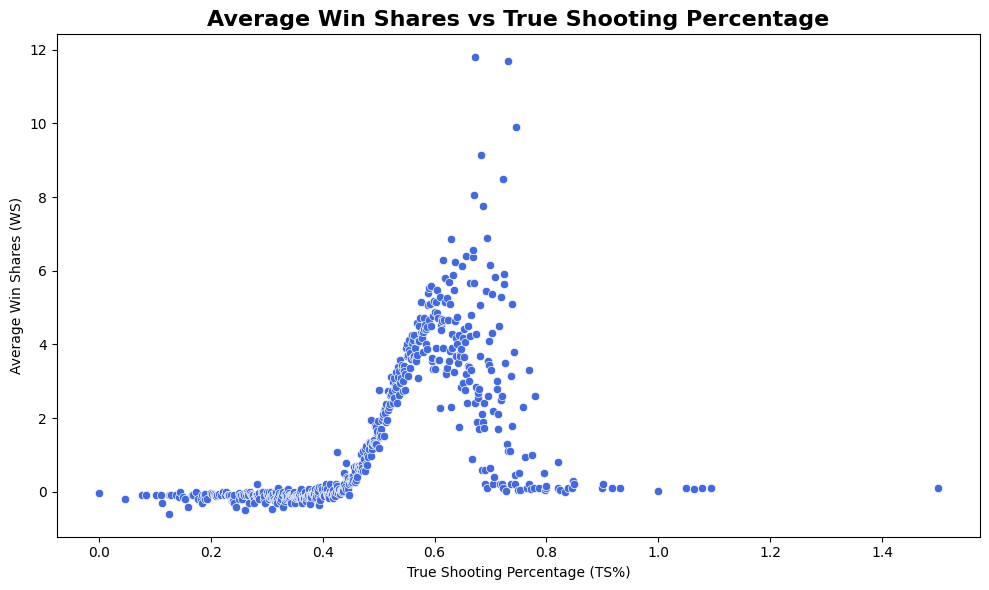

In [21]:
# WINSHARES VS TS%
# Group by TS% and calculate mean WS for each TS% value
ws_ts = main.groupby('TS%')['WS'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.scatterplot(x='TS%', y='WS', data=ws_ts, color='royalblue')
plt.title('Average Win Shares vs True Shooting Percentage', fontsize=16, fontweight='bold')
plt.xlabel('True Shooting Percentage (TS%)')
plt.ylabel('Average Win Shares (WS)')
plt.tight_layout()
plt.show()

FEATURE ENGINEERING 

In [ ]:
# Transformations 

# Points per 36 minutes
combined_df['PTS_per_36'] = (combined_df['PTS'] / combined_df['MP']).replace([np.inf, -np.inf], np.nan) * 36
combined_df['PTS_per_36'] = combined_df['PTS_per_36'].fillna(0) # Or another imputation strategy

# Efficiency Metrics 
# FG%, 3P%, FT%, eFG%, TS%, 3PAr, FTr, ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, USG%

# Undervalued Proxy 
main_df['Undervalued_Proxy'] = (main_df['